# A Diffusion Model from Scratch in Pytorch

In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video.


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


In [1]:
# Imports

import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime

# Set the seed
torch.manual_seed(42)

# Check if we are running in Google Colab
RUN_COLAB = False
if RUN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "/content/gdrive/MyDrive/Colab/GenAI_A3/"
else:
    dir = os.getcwd() + "/"

# Create a directory to store the results
name = 'local1'
now = datetime.datetime.now()
result_dir = dir + name + "_" + now.strftime("%Y-%m-%d_%H-%M-%S") + '/'
if (os.path.exists(result_dir)):
    raise Exception("The result directory exists. Please modify the name of the result directory.")
else:
    os.mkdir(result_dir)

# Investigate Celeba Dataset

In [2]:
def show_tensor_image(image):
    """
    Function to show a tensor image. It first apply the reverse transformation to the image and then plot it.

    Parameters
    image: torch.Tensor

    Returns
    None
    """

    # Recovere the RGB values and convert to a suitable format
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

# Define a custom dataset class that does not return the labels
class ImageFolderWithoutLabels(ImageFolder):
    """
    Custom dataset class that does not return the labels.
    """
    
    def __getitem__(self, index):
        # override the __getitem__ method to return only the image
        return super(ImageFolderWithoutLabels, self).__getitem__(index)[0]

Number of bathces in train_loader: 32
Length of a batch:  32
Shape of a batch:  torch.Size([3, 64, 64])


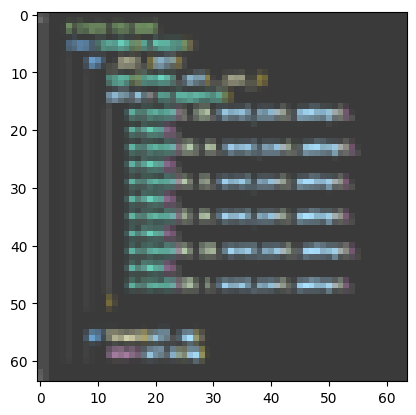

In [3]:
# DO NOT REMOVE
IMG_SIZE = 64
BATCH_SIZE = 32

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to image_size x image_size
    transforms.ToTensor(),  # Convert image to PyTorch Tensor data type
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Repeat grayscale image to 3 channels
    transforms.Lambda(lambda x: 2. * (x / x.max()) - 1.) # Normalize pixel values to [-1, 1]
])
# Load the dataset
dataset = ImageFolderWithoutLabels(root=dir + 'data/celeba', transform=transform)

# Create the data loader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# # Load the dataset from images.pt
# dataset = torch.load(dir + 'images.pt')
# print(type(dataset))

# Print some information about the dataloaders
print(f'Number of bathces in train_loader: {len(dataset)}')
print(f"Length of a batch: ", BATCH_SIZE)
print('Shape of a batch: ', dataset[0].shape)

# Show a sample image
show_tensor_image(next(iter(train_loader))[0])

# Time to iterate over the dataset

### Over a SINGLE batch of size 32

Dataloader: 0.16s

List Object: 0.0001089s

### If we use the whole dataset (200k images) we will have 6250 batches

Dataloader: 1000s = 16.7min

List Object: 0.6875s

These are the durations of iterating over the dataset within a SINGLE EPOCH


In [4]:
# Iterate over the whole dataset and count the time it takes
start = time.time()
for i, batch in enumerate(train_loader):
    pass
end = time.time()
print("Length of images: ", len(train_loader))
print("Shape of an image: ", batch[0].shape)
print("\nTime to iterate over the whole dataset:", end - start)

Length of images:  1
Shape of an image:  torch.Size([3, 64, 64])

Time to iterate over the whole dataset: 0.1504383087158203


# Building the Diffusion Model


## Step 1: The forward process = Noise scheduler




We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [5]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

### Do a forward pass

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_8893/2296189259.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_8893/1468920839.py:17: RuntimeWarning: invalid value encountered in cast
  transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),


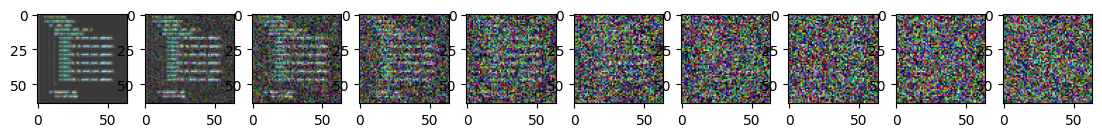

In [6]:
# Simulate forward diffusion
# image = next(iter(train_loader))
image = dataset[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: The backward process = U-Net



For a great introduction to UNets, have a look at this post: https://amaarora.github.io/2020/09/13/unet.html.


**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the ouput the noise in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The Timestep is encoded by the transformer Sinusoidal Embedding
- We output one single value (mean), because the variance is fixed


In [7]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


**Further improvements that can be implemented:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization
- GroupNormalization
- Attention
- ...

## Step 3: The loss



**Key Takeaways:**
- After some maths we end up with a very simple loss function
- There are other possible choices like L2 loss ect.


In [8]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    # return F.l1_loss(noise, noise_pred)
    return F.mse_loss(noise, noise_pred)

## Sampling
- Without adding @torch.no_grad() we quickly run out of memory, because pytorch tacks all the previous images for gradient calculation
- Because we pre-calculated the noise variances for the forward pass, we also have to use them when we sequentially perform the backward process

In [9]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(epoch, step):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.savefig(result_dir + f"image_epoch_{epoch}_step_{step}.png")
    plt.show()

## Initialize the model

In [10]:
# Set the device
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

# Initialize the model
model = SimpleUnet().to(device)
print("Num params: ", sum(p.numel() for p in model.parameters()))

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Save the hyperparameters to a file
with open(result_dir + 'hyperparameters.txt', 'w') as f:
    f.write(f"IMG_SIZE: {IMG_SIZE}\n\n")
    f.write(f"BATCH_SIZE: {BATCH_SIZE}\n\n")
    f.write(f"device: {device}\n\n")
    f.write(f"T: {T}\n\n")
    f.write(f"optimizer: {optimizer}\n\n")
    f.write(f"Num params: , {sum(p.numel() for p in model.parameters())}\n\n")
    f.write(f"model: {model}\n\n")

Using device:  mps
Num params:  62438883


## Training

Number of batches:  32
Epoch 0 | Loss: 0.748088002204895


/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_8893/1459195040.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


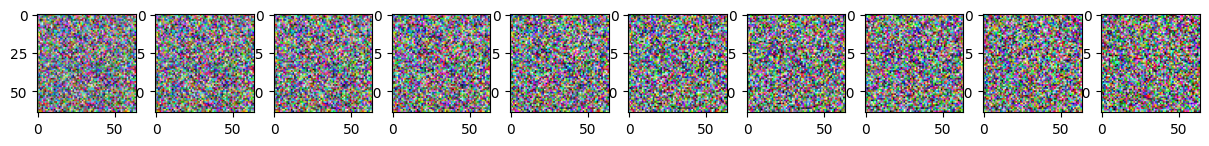

Epoch 0 | Loss: 0.748088002204895


In [12]:
epochs = 1 # Try more!
print("Number of batches: ", len(dataset))

# Training loop
train_loss = []
for epoch in range(epochs):
    running_loss = 0.0
    for step, batch in enumerate(train_loader):
      
      # get the current batch size
      current_batch_size = batch.shape[0]

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Initialize the timestep
      t = torch.randint(0, T, (current_batch_size,), device=device).long()

      # Do forward pass and get the loss
      loss = get_loss(model, batch, t)

      # Backward pass
      loss.backward()
      optimizer.step()

      # Accumulate the loss
      running_loss += loss.item()

      # TODO: Implement best model saving
      if step % 900 == 0:

        # Print loss
        print(f"Epoch {epoch} | Loss: {loss.item()}")

        # Plot the denoising process
        sample_plot_image(epoch, step)
        
        # Save the model every 10 epochs
        if epoch % 5 == 0:
          # Save the model
          torch.save(model.state_dict(), f"{result_dir}/model_epoch_{epoch}_step_{step}.pth")
    
    # Store the loss for the epoch
    train_loss.append(running_loss/len(train_loader))

    # Print the loss vs epoch
    print(f"Epoch {epoch} | Loss: {train_loss[-1]}")

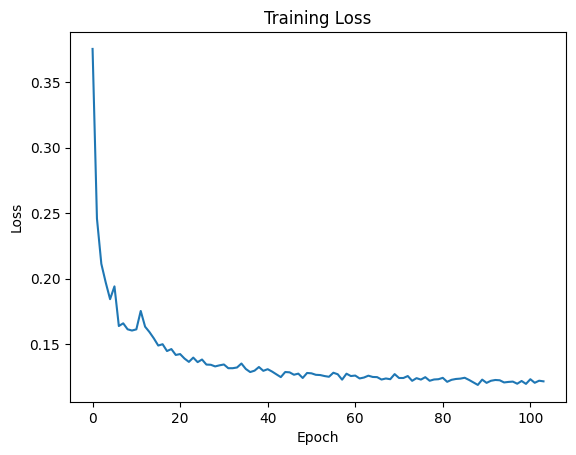

In [ ]:
# Plot the loss
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(result_dir + "training_loss.png")
plt.show()

# Save the train_loss
torch.save(train_loss, result_dir + "train_loss.pt")